In [6]:
!pip install ultralytics==8.0.40

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.3.46
    Uninstalling ultralytics-8.3.46:
      Successfully uninstalled ultralytics-8.3.46


In [7]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import tensorflow as tf
from PIL import Image
from scipy.io import loadmat
from skimage.metrics import peak_signal_noise_ratio, structural_similarity as ssim
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, ReLU, Reshape
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Lambda
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Load mall dataset
mall_gt = loadmat('/content/drive/My Drive/Colab Notebooks/mall_gt.mat')

# Create dataframe with image info and annotations
dataFrame = pd.DataFrame({
    'count': mall_gt['count'].flatten(),
    'annotations': [frame_data[0][0][0] for frame_data in mall_gt['frame'][0]]})
dataFrame = dataFrame.reset_index()
dataFrame = dataFrame.rename({'index': 'frame_id'}, axis=1)
dataFrame.frame_id = dataFrame.index + 1
dataFrame['image_name'] = dataFrame['frame_id'].apply(lambda x: f'seq_{x:06d}.jpg')


dataFrame

,frame_id,count,annotations,image_name
0,1,29,"[[126.77986348122866, 60.70477815699661], [116...",seq_000001.jpg
1,2,30,"[[57.155290102389046, 199.13481228668945], [87...",seq_000002.jpg
2,3,35,"[[118.73899371069183, 43.77044025157227], [134...",seq_000003.jpg
3,4,31,"[[140.87735849056602, 44.77672955974833], [151...",seq_000004.jpg
4,5,26,"[[123.77044025157232, 51.82075471698107], [145...",seq_000005.jpg
...,...,...,...,...
1995,1996,27,"[[454.8737166324436, 45.34599589322369], [462....",seq_001996.jpg
1996,1997,27,"[[367.48151950718693, 59.14476386036961], [395...",seq_001997.jpg
1997,1998,25,"[[22.512320328542103, 245.09958932238186], [73...",seq_001998.jpg
1998,1999,26,"[[22.512320328542103, 290.43839835728943], [99...",seq_001999.jpg


In [10]:
# create grid for each image and head positions
def create_head_count_grid(image_shape, head_locations):
    height, width = image_shape[:2]
    grid = np.zeros((10, 10), dtype=np.int32)
    xScale = 10.0 / width
    yScale = 10.0 / height

    if len(head_locations) > 0:
        head_coords = np.array(head_locations)
        gridX = np.clip((head_coords[:, 0] * xScale).astype(int), 0, 9)
        gridY = np.clip((head_coords[:, 1] * yScale).astype(int), 0, 9)

        for x, y in zip(gridX, gridY):
            grid[y, x] += 1

    return grid

In [11]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, shuffle=True, is_training=True):
        self.df = dataframe.sample(frac=1).reset_index(drop=True) if shuffle else dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.is_training = is_training

    def __len__(self):
        return len(self.df) // self.batch_size

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size: (idx + 1) * self.batch_size]
        Xbatch = []
        ybatch = []

        for _, row in batch_df.iterrows():
            img_path = f"/content/drive/My Drive/Colab Notebooks/frames/{row['image_name']}"
            image = Image.open(img_path)
            image = np.array(image) / 255.0

            # Apply data augmentation for training
            if self.is_training == True:
                image = tf.image.random_brightness(image, max_delta=0.2)
                image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
                image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
                image = tf.image.random_hue(image, max_delta=0.1)

            # Create density map
            density_map = create_head_count_grid(image.shape, row.annotations)
            ybatch.append(density_map)

            Xbatch.append(image)

        return np.array(Xbatch), np.expand_dims(np.array(ybatch), axis=-1)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [12]:
# Split data into train/val/test sets
train_val_dataFrame, test_dataFrame = train_test_split(dataFrame, test_size=0.15, random_state=42)
train_dataFrame, val_dataFrame = train_test_split(train_val_dataFrame, test_size=0.176, random_state=42)

# Initialize data generators
trainData = DataGenerator(train_dataFrame, batch_size=64, shuffle=True, is_training=True)
valData = DataGenerator(val_dataFrame, batch_size=64, shuffle=True, is_training=True)
testData = DataGenerator(test_dataFrame, batch_size=64, shuffle=False, is_training=False)

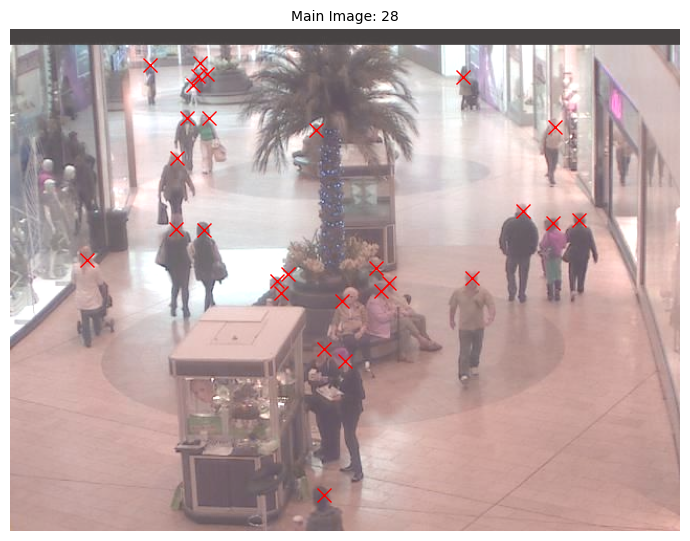

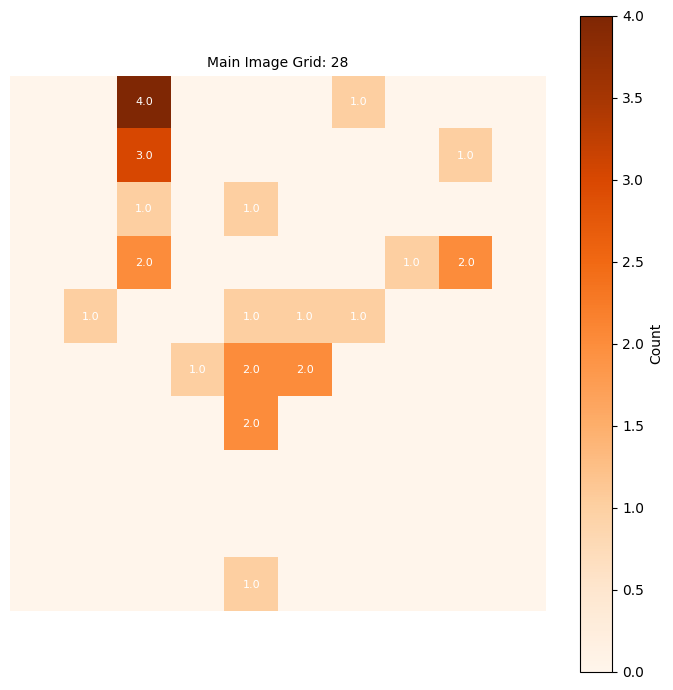

In [36]:
# a sample image and its grid map
X_sample, y_sample = trainData[0]
sample_image = X_sample[0]
sample_grid = y_sample[0]

grid_data = sample_grid.squeeze()
total_count = np.sum(grid_data)

# Plot the original image in a separate figure
plt.figure(figsize=(7, 7))
plt.imshow(sample_image)
plt.title(f'Main Image: {total_count:.0f}', fontsize=10)

# annotations
batch_idx = 0
sample_row = trainData.df.iloc[batch_idx * trainData.batch_size]
sample_annotations = sample_row.annotations

# crosses at head positions
for annotation in sample_annotations:
    x, y = annotation
    plt.plot(x, y, 'rx', markersize=10)

plt.axis('off')
plt.tight_layout()

plt.savefig('original_image.png')

plt.show()

# grid map
plt.figure(figsize=(7, 7))  # Set the same size for the second image
grid_img = plt.imshow(grid_data, cmap='Oranges')
plt.title(f'Main Image Grid: {total_count:.0f}', fontsize=10)
plt.colorbar(grid_img, label='Count')

# text annotations each cell
for i in range(grid_data.shape[0]):
    for j in range(grid_data.shape[1]):
        count = grid_data[i, j]
        if count > 0:
            plt.text(j, i, f'{count:.1f}', ha='center', va='center', color='white', fontsize=8)

plt.axis('off')
plt.tight_layout()

plt.savefig('grid_map.png')

plt.show()


In [ ]:
# Initialize the model
model = Sequential()

model.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dense(400, activation='relu'))

# Output layer for 10x10 grid
model.add(Dense(100, activation='linear'))
model.add(Reshape((10, 10, 1)))
model.add(ReLU())

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-6), loss='mean_squared_error', metrics=['mean_absolute_error'])

early_stopping_callback = EarlyStopping(monitor='val_loss',
                                      patience=10,
                                      verbose=1,
                                      restore_best_weights=True)

# Train the model
training_history = model.fit(trainData,
                           epochs=100,
                           validation_data=valData,
                           callbacks=[early_stopping_callback],
                           verbose=1)

In [ ]:
model.save('CNN.keras')

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(training_history.history['loss'], 'b-', label='Training')
plt.plot(training_history.history['val_loss'], 'r--', label='Validation')
plt.title('Model Training Results')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.savefig('MSE.png')
plt.show()

In [13]:
model = load_model('/content/drive/My Drive/Colab Notebooks/MyCNN.keras')

In [14]:
CNNpredictions = []
Orgloc = []
perGridMSE = []
perGridMAE = []

for i in range(len(testData)):
    batch_x, _ = testData[i]

    batch_pred = model.predict(batch_x)


    batch_true_counts = [len(testData.df.iloc[j].annotations) for j in range(i * testData.batch_size, min((i + 1) * testData.batch_size, len(testData.df)))]
    Orgloc.extend(batch_true_counts)

    # Sum the predicted density map
    pred_counts = np.sum(batch_pred, axis=(1, 2, 3))
    CNNpredictions.extend(pred_counts)

    # MSE and MAE for each grid
    for j in range(batch_pred.shape[0]):
        true_grid = create_head_count_grid(batch_x[j].shape, testData.df.iloc[i * testData.batch_size + j].annotations)
        pred_grid = batch_pred[j, :, :, 0]

        # Calculate MSE
        grid_mse = mean_squared_error(true_grid.flatten(), pred_grid.flatten())
        perGridMSE.append(grid_mse)

        # Calculate MAE
        grid_mae = mean_absolute_error(true_grid.flatten(), pred_grid.flatten())
        perGridMAE.append(grid_mae)

CNNpredictions = np.array(CNNpredictions)
Orgloc = np.array(Orgloc)

print(f'Prediction Statistics:')
print(f'Average predicted count: {np.mean(CNNpredictions):.1f}')
print(f'Average true count: {np.mean(Orgloc):.1f}')
print(f'Max predicted count: {np.max(CNNpredictions):.1f}')
print(f'Max true count: {np.max(Orgloc):.1f}')
print(f'Min predicted count: {np.min(CNNpredictions):.1f}')
print(f'Min true count: {np.min(Orgloc):.1f}')

# Compute metrics for CNN predictions
mse = mean_squared_error(Orgloc, CNNpredictions)
mae = mean_absolute_error(Orgloc, CNNpredictions)

# Average Grid MSE and MAE
AverageGridMSE = np.mean(perGridMSE)
AverageGridMAE = np.mean(perGridMAE)

# Print MSE and MAE results
print(f'MSE in All Grids: {mse:.1f}')
print(f'MAE in All Grids: {mae:.1f}')
print(f'Average Grid MSE: {AverageGridMSE:.4f}')
print(f'Average Grid MAE: {AverageGridMAE:.4f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 52s 27s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 50s 26s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 25s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 27s/step
Prediction Statistics:
Average predicted count: 26.5
Average true count: 31.4
Max predicted count: 39.5
Max true count: 49.0
Min predicted count: 15.5
Min true count: 17.0
MSE in All Grids: 36.6
MAE in All Grids: 5.1
Average Grid MSE: 0.2068
Average Grid MAE: 0.2158


In [18]:
# YOLOv8 model
model_yolo = YOLO('yolov8n.pt')
yolo_predictions = []
Orgloc = []
perGridMSE_yolo = []
perGridMAE_yolo = []

for i in range(len(testData)):

    batch_x, _ = testData[i]

    for j, img in enumerate(batch_x):
        # Convert image to uint8 for YOLO
        img_uint8 = (img * 255).astype(np.uint8)

        results = model_yolo(img_uint8)

        # Count human detections with confidence > 0.3
        num_detections = 0
        for r in results[0].boxes.data:
            if r.tolist()[5] == 0:  # Class ID 0 corresponds to 'person' (human)
                if r.tolist()[4] > 0.3:  # Confidence threshold
                    num_detections += 1

        yolo_predictions.append(num_detections)

        true_count = len(testData.df.iloc[i * testData.batch_size + j].annotations)
        Orgloc.append(true_count)

        true_grid = create_head_count_grid(batch_x[j].shape, testData.df.iloc[i * testData.batch_size + j].annotations)

        pred_grid = np.zeros(true_grid.shape)

        grid_size = 10
        img_height, img_width = img.shape[:2]


        cell_height = img_height // grid_size
        cell_width = img_width // grid_size

        for r in results[0].boxes.data:
            if r.tolist()[5] == 0:
                if r.tolist()[4] > 0.3:
                    # Get bounding box coordinates
                    x_min, y_min, x_max, y_max = r.tolist()[:4]

                    grid_x = int(x_min // cell_width)
                    grid_y = int(y_min // cell_height)

                    pred_grid[grid_y, grid_x] += 1

        #MSE and MAE for each grid
        grid_mse = mean_squared_error(true_grid.flatten(), pred_grid.flatten())
        grid_mae = mean_absolute_error(true_grid.flatten(), pred_grid.flatten())

        # Append MSE and MAE values for each grid
        perGridMSE_yolo.append(grid_mse)
        perGridMAE_yolo.append(grid_mae)

yolo_predictions = np.array(yolo_predictions)
Orgloc = np.array(Orgloc)

# Print YOLO Prediction Statistics
print("\nYOLO Prediction Statistics:")
print(f'Average YOLO predicted count: {np.mean(yolo_predictions):.1f}')
print(f'Average true count: {np.mean(Orgloc):.1f}')
print(f'Max YOLO predicted count: {np.max(yolo_predictions):.1f}')
print(f'Max true count: {np.max(Orgloc):.1f}')
print(f'Min YOLO predicted count: {np.min(yolo_predictions):.1f}')
print(f'Min true count: {np.min(Orgloc):.1f}')

# Compute YOLO metrics
yolo_mse = mean_squared_error(Orgloc, yolo_predictions)
yolo_mae = mean_absolute_error(Orgloc, yolo_predictions)
AverageGridMSE_yolo = np.mean(perGridMSE_yolo)
AverageGridMAE_yolo = np.mean(perGridMAE_yolo)

print(f'YOLO MSE (Overall): {yolo_mse:.1f}')
print(f'YOLO MAE (Overall): {yolo_mae:.1f}')
print(f'YOLO Average Grid MSE: {AverageGridMSE_yolo:.4f}')
print(f'YOLO Average Grid MAE: {AverageGridMAE_yolo:.4f}')


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:341: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu')  # load
Ultral


YOLO Prediction Statistics:
Average YOLO predicted count: 16.4
Average true count: 31.4
Max YOLO predicted count: 31.0
Max true count: 49.0
Min YOLO predicted count: 6.0
Min true count: 17.0
YOLO MSE (Overall): 246.3
YOLO MAE (Overall): 15.0
YOLO Average Grid MSE: 0.4073
YOLO Average Grid MAE: 0.2471


In [ ]:
# Show first image as sample
sample_batch = testData[0]
sample_image = sample_batch[0][0]
sample_image_uint8 = (sample_image * 255).astype(np.uint8)
sample_results = model_yolo(sample_image_uint8)

plt.figure(figsize=(15, 10))
plt.imshow(sample_image)
plt.title("Sample YOLO Detection")
for r in sample_results[0].boxes.data:
    x1, y1, x2, y2, conf, cls = r.tolist()
    if cls == 0 and conf > 0.3:
        head_x = int((x1 + x2) / 2)
        head_y = int(y1)
        plt.plot(head_x, head_y, 'rx', markersize=10)
plt.savefig('YOLO_Sample')
plt.show()

In [19]:
# Get a random image from testData
random_idx = np.random.randint(0, len(testData.df))
batch_idx = random_idx // testData.batch_size
img_idx = random_idx % testData.batch_size

# Get the test image and annotations
test_batch = testData[batch_idx]
test_image = test_batch[0][img_idx]
test_annotations = testData.df.iloc[random_idx].annotations

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step


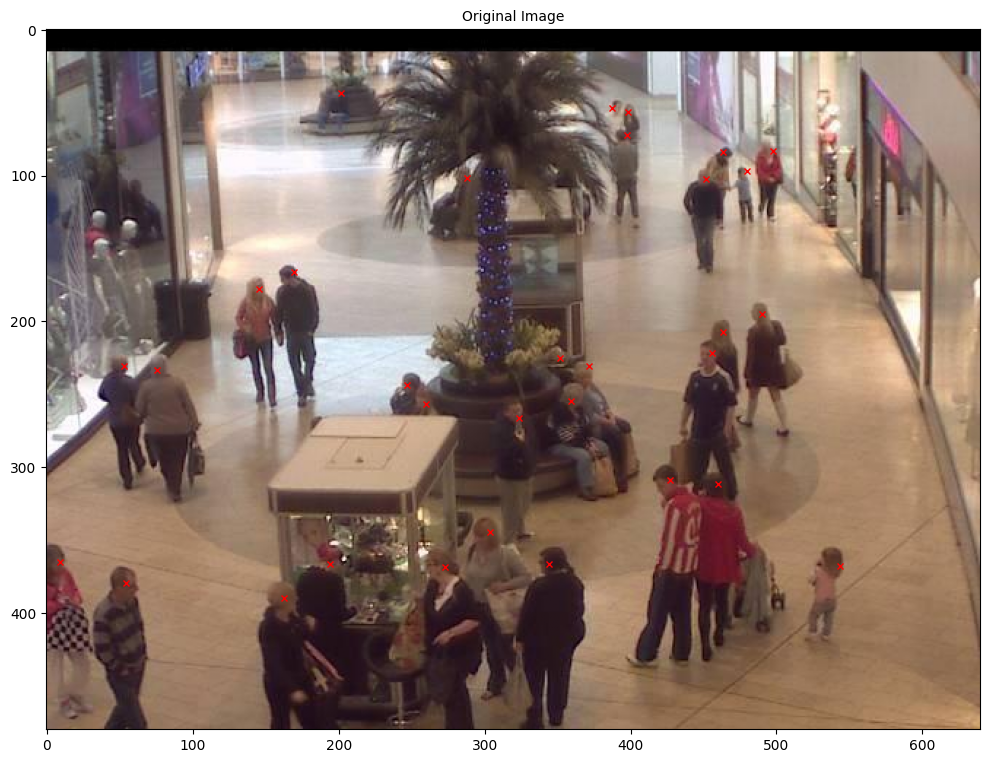

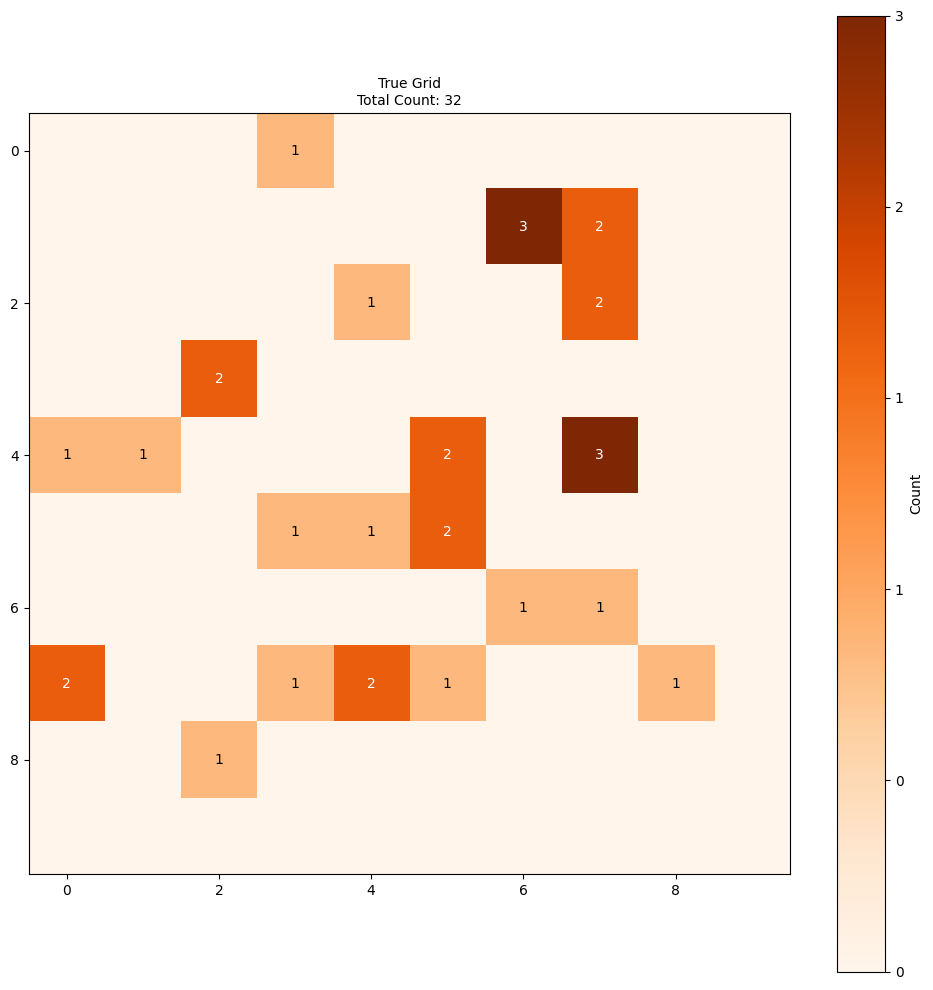

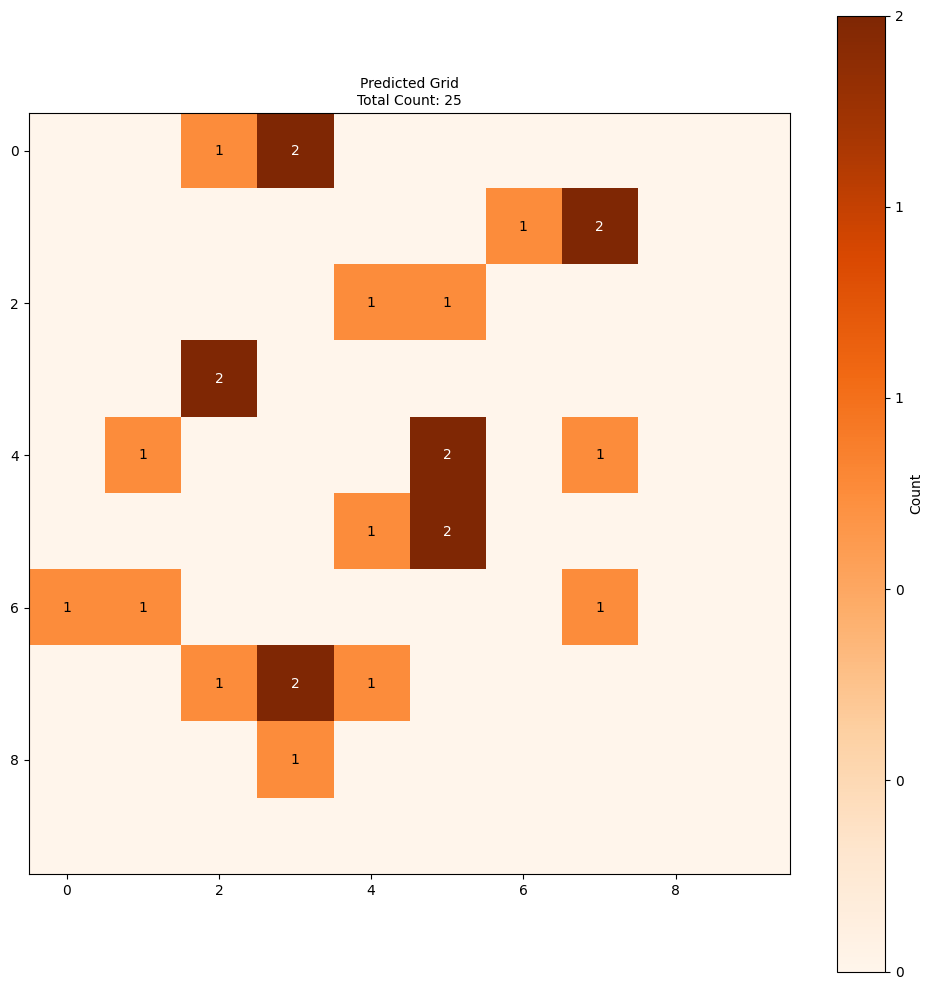


CNN Detection Metrics:
------------------------------------------------------------
MSE: 0.3100
MAE: 0.2300
------------------------------------------------------------
Format: (row, col): True Count → Predicted Count [Absolute Error]
(1, 6): 3 → 1 [Error: 2]
(2, 7): 2 → 0 [Error: 2]
(4, 7): 3 → 1 [Error: 2]
(7, 0): 2 → 0 [Error: 2]
(0, 2): 0 → 1 [Error: 1]
(0, 3): 1 → 2 [Error: 1]
(2, 5): 0 → 1 [Error: 1]
(4, 0): 1 → 0 [Error: 1]
(5, 3): 1 → 0 [Error: 1]
(6, 0): 0 → 1 [Error: 1]
(6, 1): 0 → 1 [Error: 1]
(6, 6): 1 → 0 [Error: 1]
(7, 2): 0 → 1 [Error: 1]
(7, 3): 1 → 2 [Error: 1]
(7, 4): 2 → 1 [Error: 1]
(7, 5): 1 → 0 [Error: 1]
(7, 8): 1 → 0 [Error: 1]
(8, 2): 1 → 0 [Error: 1]
(8, 3): 0 → 1 [Error: 1]
(1, 7): 2 → 2 [Error: 0]
(2, 4): 1 → 1 [Error: 0]
(3, 2): 2 → 2 [Error: 0]
(4, 1): 1 → 1 [Error: 0]
(4, 5): 2 → 2 [Error: 0]
(5, 4): 1 → 1 [Error: 0]
(5, 5): 2 → 2 [Error: 0]
(6, 7): 1 → 1 [Error: 0]


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate CNN error metrics (MSE, MAE)
def calculate_cnn_errors(true_grid, predicted_grid):
    mse = mean_squared_error(true_grid.flatten(), predicted_grid.flatten())
    mae = mean_absolute_error(true_grid.flatten(), predicted_grid.flatten())

    cell_errors = []
    for i in range(true_grid.shape[0]):
        for j in range(true_grid.shape[1]):
            if true_grid[i, j] > 0 or predicted_grid[i, j] > 0:
                cell_errors.append({
                    'position': (i, j),
                    'true_count': true_grid[i, j],
                    'predicted_count': predicted_grid[i, j],
                    'error': abs(true_grid[i, j] - predicted_grid[i, j])
                })

    return {
        'MSE': mse,
        'MAE': mae,
        'cell_errors': cell_errors
    }

# Get CNN predictions
test_pred = model.predict(np.expand_dims(test_image, axis=0))[0]
predicted_grid = np.round(test_pred[:, :, 0]).astype(int)
true_grid = create_head_count_grid(test_image.shape, test_annotations)

# CNN error
cnn_errors = calculate_cnn_errors(true_grid, predicted_grid)

plt.figure(figsize=(10, 10))
plt.imshow(test_image)
plt.title('Original Image', fontsize=10)

# Plot annotations
for x, y in test_annotations:
    plt.plot(x, y, 'rx', markersize=5)
plt.axis('on')
plt.tight_layout()
plt.savefig(f'original_image_{random_idx}.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


plt.figure(figsize=(10, 10))
max_true = np.max(true_grid)
normalized_true = true_grid / max_true if max_true > 0 else true_grid
im_true = plt.imshow(normalized_true, cmap='Oranges')
cbar = plt.colorbar(im_true, label='Count')
cbar.ax.tick_params(labelsize=10)


cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels([int(x * max_true) for x in np.linspace(0, 1, 6)])
plt.title(f'True Grid\nTotal Count: {np.sum(true_grid)}', fontsize=10)

# Add count numbers to each cell
for i in range(true_grid.shape[0]):
    for j in range(true_grid.shape[1]):
        count = true_grid[i, j]
        if count > 0:
            color = 'white' if normalized_true[i, j] > 0.5 else 'black'
            plt.text(j, i, str(int(count)), ha='center', va='center', color=color, fontsize=10)

plt.tight_layout()
plt.savefig(f'true_grid_heatmap_{random_idx}.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


plt.figure(figsize=(10, 10))
max_pred = np.max(predicted_grid)
normalized_pred = predicted_grid / max_pred if max_pred > 0 else predicted_grid
im_pred = plt.imshow(normalized_pred, cmap='Oranges')
cbar = plt.colorbar(im_pred, label='Count')
cbar.ax.tick_params(labelsize=10)


cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels([int(x * max_pred) for x in np.linspace(0, 1, 6)])
plt.title(f'Predicted Grid\nTotal Count: {np.sum(predicted_grid)}', fontsize=10)

# Add count numbers to each cell
for i in range(predicted_grid.shape[0]):
    for j in range(predicted_grid.shape[1]):
        count = predicted_grid[i, j]
        if count > 0:
            color = 'white' if normalized_pred[i, j] > 0.5 else 'black'
            plt.text(j, i, str(int(count)), ha='center', va='center', color=color, fontsize=10)

plt.tight_layout()
plt.savefig(f'predicted_grid_heatmap_{random_idx}.png', dpi=300, bbox_inches='tight')  # Save predicted grid heatmap
plt.show()

# Print CNN metrics
print("\nCNN Detection Metrics:")
print("-" * 60)
print(f"MSE: {cnn_errors['MSE']:.4f}")
print(f"MAE: {cnn_errors['MAE']:.4f}")

print("-" * 60)
print("Format: (row, col): True Count → Predicted Count [Absolute Error]")
for cell_error in sorted(cnn_errors['cell_errors'], key=lambda x: x['error'], reverse=True):
    i, j = cell_error['position']
    print(f"({i}, {j}): {cell_error['true_count']} → {cell_error['predicted_count']} [Error: {cell_error['error']}]")



0: 480x640 24 persons, 1 handbag, 189.2ms
Speed: 2.0ms pre-process, 189.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


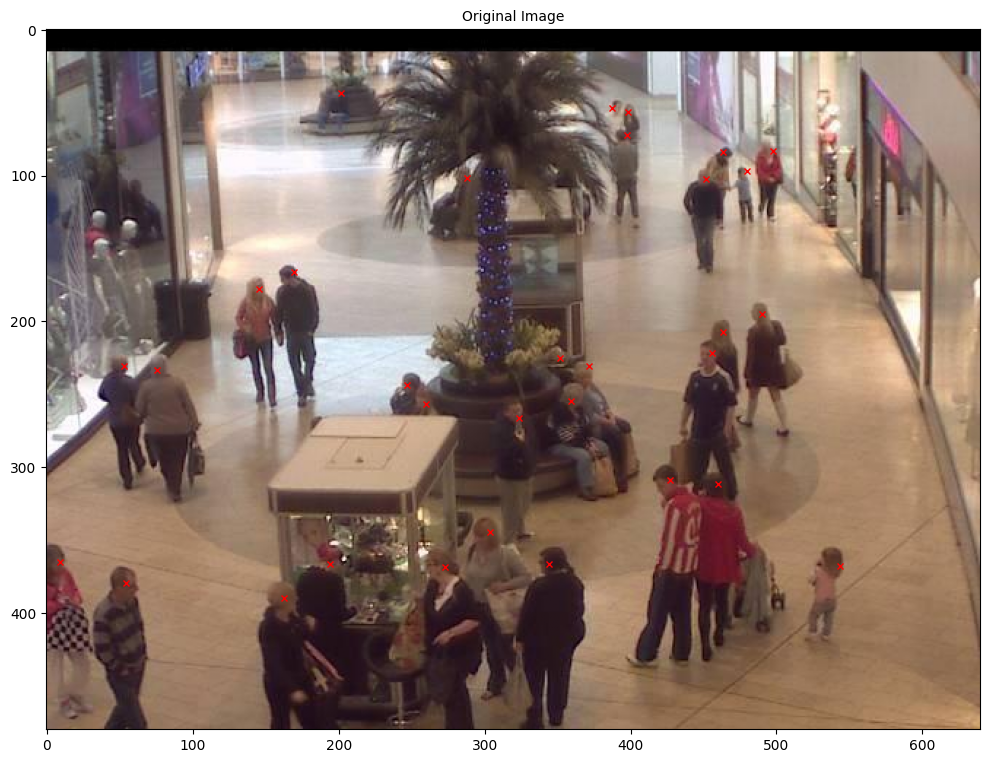

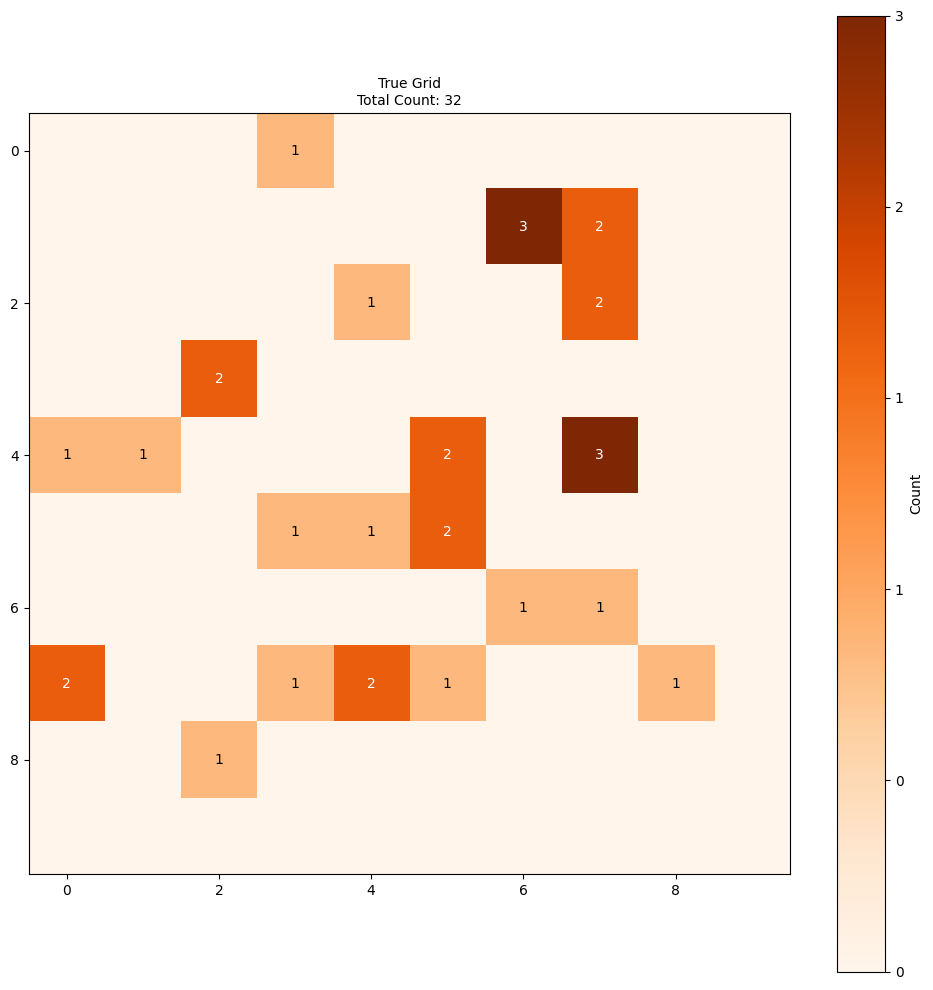

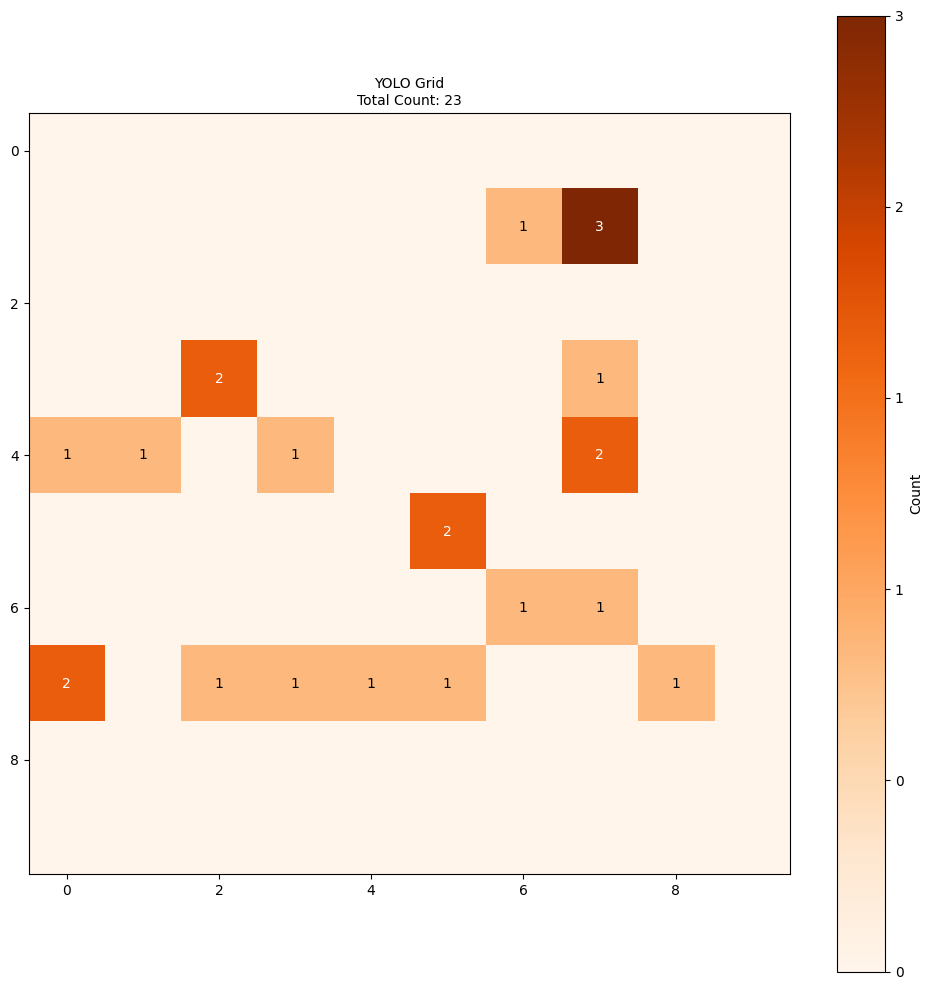


YOLO Detection Metrics:
------------------------------------------------------------
MSE: 0.2300
MAE: 0.1700

Cell-by-cell comparison (non-zero cells only):
------------------------------------------------------------
Format: (row, col): True Count → YOLO Count [Absolute Error]
(1, 6): 3 → 1.0 [Error: 2.0]
(2, 7): 2 → 0.0 [Error: 2.0]
(4, 5): 2 → 0.0 [Error: 2.0]
(0, 3): 1 → 0.0 [Error: 1.0]
(1, 7): 2 → 3.0 [Error: 1.0]
(2, 4): 1 → 0.0 [Error: 1.0]
(3, 7): 0 → 1.0 [Error: 1.0]
(4, 3): 0 → 1.0 [Error: 1.0]
(4, 7): 3 → 2.0 [Error: 1.0]
(5, 3): 1 → 0.0 [Error: 1.0]
(5, 4): 1 → 0.0 [Error: 1.0]
(7, 2): 0 → 1.0 [Error: 1.0]
(7, 4): 2 → 1.0 [Error: 1.0]
(8, 2): 1 → 0.0 [Error: 1.0]
(3, 2): 2 → 2.0 [Error: 0.0]
(4, 0): 1 → 1.0 [Error: 0.0]
(4, 1): 1 → 1.0 [Error: 0.0]
(5, 5): 2 → 2.0 [Error: 0.0]
(6, 6): 1 → 1.0 [Error: 0.0]
(6, 7): 1 → 1.0 [Error: 0.0]
(7, 0): 2 → 2.0 [Error: 0.0]
(7, 3): 1 → 1.0 [Error: 0.0]
(7, 5): 1 → 1.0 [Error: 0.0]
(7, 8): 1 → 1.0 [Error: 0.0]


In [29]:
def calculate_yolo_grid_errors(true_grid, yolo_grid):
    mse = mean_squared_error(true_grid.flatten(), yolo_grid.flatten())
    mae = mean_absolute_error(true_grid.flatten(), yolo_grid.flatten())

    cell_errors = []
    for i in range(true_grid.shape[0]):
        for j in range(true_grid.shape[1]):
            if true_grid[i, j] > 0 or yolo_grid[i, j] > 0:
                cell_errors.append({
                    'position': (i, j),
                    'true_count': true_grid[i, j],
                    'predicted_count': yolo_grid[i, j],
                    'error': abs(true_grid[i, j] - yolo_grid[i, j])
                })

    return {
        'MSE': mse,
        'MAE': mae,
        'cell_errors': cell_errors
    }

# Convert image to uint8 for YOLO
test_image_uint8 = (test_image * 255).astype(np.uint8)

yolo_grid = np.zeros((10, 10), dtype=np.float32)
height, width = test_image.shape[:2]
cell_height = height / 10
cell_width = width / 10

results = model_yolo(test_image_uint8)
for r in results[0].boxes.data:
    x1, y1, x2, y2, conf, cls = r.tolist()
    if cls == 0 and conf > 0.3:
        head_x = int((x1 + x2) / 2)
        head_y = int(y1)

        grid_i = min(9, max(0, int(head_y / cell_height)))
        grid_j = min(9, max(0, int(head_x / cell_width)))
        yolo_grid[grid_i, grid_j] += 1

# Create true grid
true_grid = create_head_count_grid(test_image.shape, test_annotations)

# Calculate YOLO error metrics
yolo_errors = calculate_yolo_grid_errors(true_grid, yolo_grid)

# Plot and save the original image
plt.figure(figsize=(10, 10))
plt.imshow(test_image)
plt.title('Original Image', fontsize=10)

# Plot annotations
for x, y in test_annotations:
    plt.plot(x, y, 'rx', markersize=5)
plt.axis('on')
plt.tight_layout()
plt.savefig(f'original_image_{random_idx}.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Plot and save the true grid heatmap
plt.figure(figsize=(10, 10))
max_true = np.max(true_grid)
normalized_true = true_grid / max_true if max_true > 0 else true_grid
im_true = plt.imshow(normalized_true, cmap='Oranges')
cbar = plt.colorbar(im_true, label='Count')
cbar.ax.tick_params(labelsize=10)
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels([int(x * max_true) for x in np.linspace(0, 1, 6)])
plt.title(f'True Grid\nTotal Count: {np.sum(true_grid)}', fontsize=10)

# Add count numbers to each cell
for i in range(true_grid.shape[0]):
    for j in range(true_grid.shape[1]):
        count = true_grid[i, j]
        if count > 0:
            color = 'white' if normalized_true[i, j] > 0.5 else 'black'
            plt.text(j, i, str(int(count)), ha='center', va='center', color=color, fontsize=10)

plt.tight_layout()
plt.savefig(f'true_grid_heatmap_{random_idx}.png', dpi=300, bbox_inches='tight')  # Save true grid heatmap
plt.show()
plt.close()

# Plot and save the YOLO grid heatmap
plt.figure(figsize=(10, 10))
max_yolo = np.max(yolo_grid)
normalized_yolo = yolo_grid / max_yolo if max_yolo > 0 else yolo_grid
im_yolo = plt.imshow(normalized_yolo, cmap='Oranges')
cbar = plt.colorbar(im_yolo, label='Count')
cbar.ax.tick_params(labelsize=10)
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels([int(x * max_yolo) for x in np.linspace(0, 1, 6)])
plt.title(f'YOLO Grid\nTotal Count: {int(np.sum(yolo_grid))}', fontsize=10)

# Add count numbers to each cell
for i in range(yolo_grid.shape[0]):
    for j in range(yolo_grid.shape[1]):
        count = yolo_grid[i, j]
        if count > 0:
            color = 'white' if normalized_yolo[i, j] > 0.5 else 'black'
            plt.text(j, i, str(int(count)), ha='center', va='center', color=color, fontsize=10)

plt.tight_layout()
plt.savefig(f'yolo_grid_heatmap_{random_idx}.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Print YOLO metrics
print("\nYOLO Detection Metrics:")
print("-" * 60)
print(f"MSE: {yolo_errors['MSE']:.4f}")
print(f"MAE: {yolo_errors['MAE']:.4f}")

print("\nCell-by-cell comparison (non-zero cells only):")
print("-" * 60)
print("Format: (row, col): True Count → YOLO Count [Absolute Error]")
for cell_error in sorted(yolo_errors['cell_errors'], key=lambda x: x['error'], reverse=True):
    i, j = cell_error['position']
    print(f"({i}, {j}): {cell_error['true_count']} → {cell_error['predicted_count']} [Error: {cell_error['error']}]")
